In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
data = datasets.ImageFolder('./sar_data/', transform = transform) # dataset oluşturulması

np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 1628 data points.
Train Dataset has 1139 data points
Test Dataset has 489 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 16
num_epochs = 20
learning_rate = 0.0003
###HYPERPARAMETERS###

In [4]:
test_dataset[325]
alongside_cout = building_cout = road_cout = vegetation_cout = water_cout = 0
train_alongside_cout = train_building_cout = train_road_cout = train_vegetation_cout = train_water_cout = 0
for x in range(len(test_dataset)):
    a, b = test_dataset[x]
    if b == 0:
        alongside_cout +=1
    if b == 1:
        building_cout+=1
    if b == 2:
        road_cout+=1
    if b == 3:
        vegetation_cout+=1
    if b == 4:
        water_cout+=1

for x in range(len(train_dataset)):
    a, b = train_dataset[x]
    if b == 0:
        train_alongside_cout +=1
    if b == 1:
        train_building_cout+=1
    if b == 2:
        train_road_cout+=1
    if b == 3:
        train_vegetation_cout+=1
    if b == 4:
        train_water_cout+=1

print(f"Alongside number of samples in train set : {train_alongside_cout}") # hangi kategoride kaç veri var
print(f"Alongside number of samples in test set : {alongside_cout}")
print(f"Building number of samples in train set : {train_building_cout}")
print(f"Building number of samples in test set : {building_cout}")
print(f"Road number of samples in train set : {train_road_cout}")
print(f"Road number of samples in test set : {road_cout}")
print(f"Vegetation number of samples in train set : {train_vegetation_cout}")
print(f"Vegetation number of samples in test set : {vegetation_cout}")
print(f"Water number of samples in train set : {train_water_cout}")
print(f"Water number of samples in test set : {water_cout}")

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

Alongside number of samples in train set : 168
Alongside number of samples in test set : 48
Building number of samples in train set : 282
Building number of samples in test set : 110
Road number of samples in train set : 271
Road number of samples in test set : 121
Vegetation number of samples in train set : 204
Vegetation number of samples in test set : 108
Water number of samples in train set : 214
Water number of samples in test set : 102


In [5]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(576, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}

model = ResNet(**net_args)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time



arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Step [71/72], Loss: 0.6022: Batch Loss : 0.769052451555158
Epoch [2/20], Step [71/72], Loss: 0.1169: Batch Loss : 0.31871194465899133
Epoch [3/20], Step [71/72], Loss: 0.0673: Batch Loss : 0.22335815933388722
Epoch [4/20], Step [71/72], Loss: 0.0532: Batch Loss : 0.14992838394893726
Epoch [5/20], Step [71/72], Loss: 0.2663: Batch Loss : 0.1752928140717493
Epoch [6/20], Step [71/72], Loss: 0.0536: Batch Loss : 0.15355299392216643
Epoch [7/20], Step [71/72], Loss: 0.2148: Batch Loss : 0.16287019617960485
Epoch [8/20], Step [71/72], Loss: 0.0914: Batch Loss : 0.11133009908904493
Epoch [9/20], Step [71/72], Loss: 0.0491: Batch Loss : 0.09744901094638125
Epoch [10/20], Step [71/72], Loss: 0.0540: Batch Loss : 0.10119308982516678
Epoch [11/20], Step [71/72], Loss: 0.0154: Batch Loss : 0.08224974808768487
Epoch [12/20], Step [71/72], Loss: 0.2633: Batch Loss : 0.08917090711249433
Epoch [13/20], Step [71/72], Loss: 0.0229: Batch Loss : 0.0898734590327236
Epoch [14/20], Step [71/7

In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 91.58903360366821 sn


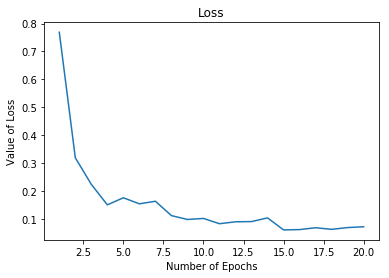

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

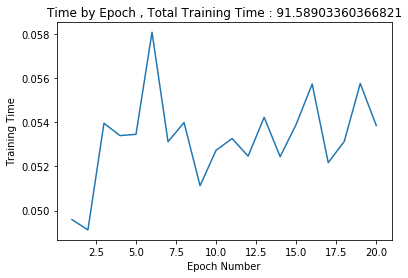

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

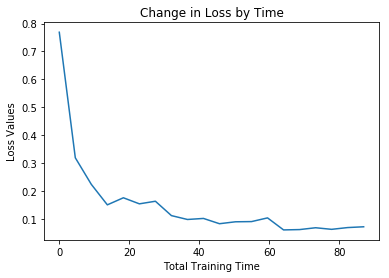

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

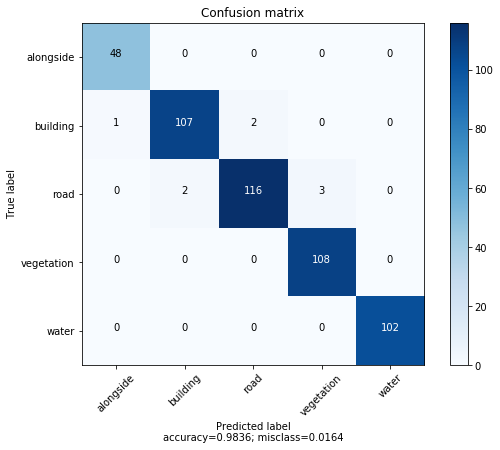

The Accuracy : 98.3640081799591
The Precision : 98.34534066624165
The Recall : 98.62809917355371
The F1 Score : 98.47744676710637


In [11]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["alongside", "building", "road" ,"vegetation", "water"], title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")